# ICR – Identifying Age-Related Conditions: TabPFN v2 Baseline

Ziel: Eine **saubere, reproduzierbare Baseline** mit **TabPFN (v2)** für die Kaggle-Competition
**ICR – Identifying Age-Related Conditions**.

Enthält:
- sinnvolles Preprocessing (Encoding, Missing Values, Outlier-Clipping, einfache Feature-Stats)
- Stratified K-Fold CV + **Balanced Log Loss**
- Training auf allen Daten + `submission.csv`

**Hinweis zu TabPFN-Gewichten:** TabPFN lädt Modellgewichte beim ersten Run automatisch. Je nach Version/Lizenz kann ein Zugriff über HuggingFace erforderlich sein. Siehe Setup-Zelle unten. (Doku/FAQ) citeturn1view1turn2view0


In [10]:
# (Kaggle) Installation – nur falls tabpfn nicht vorhanden ist
# !pip -q install -U tabpfn scikit-learn pandas numpy

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss

# TabPFN
from tabpfn import TabPFNClassifier
try:
    from tabpfn.constants import ModelVersion
except Exception:
    ModelVersion = None

# Optional: Calibration (für LogLoss manchmal hilfreich)
from sklearn.calibration import CalibratedClassifierCV

import torch

print("torch:", torch.__version__)
try:
    import tabpfn
    print("tabpfn:", tabpfn.__version__)
except Exception as e:
    print("tabpfn import ok, version unknown:", e)


torch: 2.10.0+cpu
tabpfn: 6.4.1


## Daten aufteilen: data.csv → train.csv / test.csv

Stratifizierter 80/20-Split aus `data.csv`. `test.csv` enthält kein `Class`-Label (wie beim Kaggle-Submit).

In [11]:
from sklearn.model_selection import train_test_split

_DATA_DIR = "../data"
_all = pd.read_csv(os.path.join(_DATA_DIR, "data.csv"))

_train, _test = train_test_split(
    _all, test_size=0.2, random_state=42, stratify=_all["Class"]
)

# test.csv ohne Class-Label (analog zu Kaggle-Testset)
_test_no_label = _test.drop(columns=["Class"])

_train.to_csv(os.path.join(_DATA_DIR, "train.csv"), index=False)
_test_no_label.to_csv(os.path.join(_DATA_DIR, "test.csv"), index=False)

print(f"train.csv: {_train.shape}  (Class-Verteilung: {_train['Class'].value_counts().to_dict()})")
print(f"test.csv:  {_test_no_label.shape}")

del _all, _train, _test, _test_no_label

train.csv: (493, 58)  (Class-Verteilung: {0: 407, 1: 86})
test.csv:  (124, 57)


## Daten laden

Kaggle-Pfade sind voreingestellt. Lokal: `DATA_DIR` anpassen.


In [12]:
DATA_DIR = "../data"
train_path = os.path.join(DATA_DIR, "train.csv")
test_path  = os.path.join(DATA_DIR, "test.csv")

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("train:", train_df.shape)
print("test :", test_df.shape)
train_df.head()


train: (493, 58)
test : (124, 57)


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,27bfa971821f,0.170920,1549.40016,85.200147,14.487766,8.138688,5.767209,0.049938,9.560134,5.896492,...,0.173229,2.00970,0.717938,19.887676,281.460074,14301.991480,26.809805,101.938648,21.978000,0
1,667b389f278d,0.538398,4889.28330,108.548976,7.002317,8.138688,5.935530,0.073080,8.898424,14.259812,...,0.173229,0.49706,0.169325,15.673870,72.611063,1180.078956,23.676723,9.444384,21.978000,1
2,ed4a24c7ec54,0.217923,2497.85382,85.200147,19.127072,8.138688,3.561318,0.109620,7.745158,3.542112,...,0.173229,0.49706,0.067730,11.618198,72.611063,11234.645240,35.650901,26.247260,21.978000,0
3,1bcdc1af3458,0.645223,5650.31764,100.554114,268.986838,30.614472,4.287756,0.025578,11.280580,1.229900,...,18.647311,0.81519,0.128687,16.455238,108.686910,690.313428,29.176361,151.326192,0.002405,1
4,f82b07dfd7fb,1.106707,3279.32506,118.764633,48.660064,8.138688,8.212293,0.025578,9.988670,1.229900,...,0.434226,1.14086,1.713569,20.855084,72.611063,13738.933020,43.200810,21.648524,1.566000,0


In [13]:
TARGET = "Class"
ID_COL = "Id"
CAT_COL = "EJ"  # einzige kategoriale Spalte im ICR-Datensatz

assert TARGET in train_df.columns and ID_COL in train_df.columns
assert ID_COL in test_df.columns
print("Class distribution:")
display(train_df[TARGET].value_counts())

# Basic sanity: Inf -> NaN
train_df = train_df.replace([np.inf, -np.inf], np.nan)
test_df  = test_df.replace([np.inf, -np.inf], np.nan)


Class distribution:


Class
0    407
1     86
Name: count, dtype: int64

## Metric: Balanced Log Loss

Kaggle nutzt **Balanced Log Loss**. Wir implementieren sie, damit CV-Scores sinnvoll sind.


In [14]:
def balanced_log_loss(y_true, y_pred_proba, eps=1e-15):
    y_true = np.asarray(y_true).astype(int)
    p = np.clip(np.asarray(y_pred_proba), eps, 1 - eps)

    n0 = (y_true == 0).sum()
    n1 = (y_true == 1).sum()
    if n0 == 0 or n1 == 0:
        return log_loss(y_true, p)

    loss0 = -np.mean(np.log(1 - p[y_true == 0]))
    loss1 = -np.mean(np.log(p[y_true == 1]))
    return 0.5 * (loss0 + loss1)

print("sanity:", balanced_log_loss([0,1,0,1],[0.1,0.9,0.2,0.8]))


sanity: 0.164252033486018


## Preprocessing

Was wir hier machen:
1) `EJ` → 0/1 (sehr simple, weil nur 2 Kategorien)  
2) Missing Values → Median-Imputation  
3) Optional: Outlier-Clipping (Winsorizing)  
4) Einfache Row-Stats-Features (mean/std/min/max + missing_count)  
5) Standardisierung (kann man ablationieren; bei TabPFN ist es nicht immer entscheidend) citeturn2view0


In [15]:
def encode_ej(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if CAT_COL in df.columns:
        # robust mapping: falls nur A/B vorkommt
        mapping = {"A": 0, "B": 1}
        df[CAT_COL] = df[CAT_COL].map(mapping).astype("float32")
    return df

def add_row_stats(df: pd.DataFrame, exclude_cols=None) -> pd.DataFrame:
    df = df.copy()
    exclude_cols = set(exclude_cols or [])
    cols = [c for c in df.columns if c not in exclude_cols]
    # numeric-only
    X = df[cols].astype("float32")
    df["row_mean"] = X.mean(axis=1)
    df["row_std"]  = X.std(axis=1)
    df["row_min"]  = X.min(axis=1)
    df["row_max"]  = X.max(axis=1)
    df["missing_count"] = X.isna().sum(axis=1).astype("float32")
    return df

def winsorize_quantiles(df: pd.DataFrame, lower_q=0.005, upper_q=0.995, exclude_cols=None) -> pd.DataFrame:
    df = df.copy()
    exclude_cols = set(exclude_cols or [])
    cols = [c for c in df.columns if c not in exclude_cols]
    # Compute quantiles per column (numeric)
    q_low = df[cols].quantile(lower_q)
    q_hi  = df[cols].quantile(upper_q)
    df[cols] = df[cols].clip(q_low, q_hi, axis=1)
    return df

def preprocess(train_df: pd.DataFrame, test_df: pd.DataFrame, do_winsorize=True, do_scale=True):
    tr = train_df.copy()
    te = test_df.copy()

    # encode EJ
    tr = encode_ej(tr)
    te = encode_ej(te)

    # split target/id
    y = tr[TARGET].astype(int).values
    tr = tr.drop(columns=[TARGET])
    
    tr_ids = tr[ID_COL].values
    te_ids = te[ID_COL].values
    
    tr = tr.drop(columns=[ID_COL])
    te = te.drop(columns=[ID_COL])

    # simple feature engineering
    tr = add_row_stats(tr)
    te = add_row_stats(te)

    # outlier clipping (optional)
    if do_winsorize:
        tr = winsorize_quantiles(tr, exclude_cols=[])
        te = winsorize_quantiles(te, exclude_cols=[])

    # impute
    imputer = SimpleImputer(strategy="median")
    X_tr = imputer.fit_transform(tr)
    X_te = imputer.transform(te)

    # scale (optional)
    scaler = None
    if do_scale:
        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_te = scaler.transform(X_te)

    # ensure float32 for torch efficiency
    X_tr = X_tr.astype("float32")
    X_te = X_te.astype("float32")
    return X_tr, y, X_te, tr_ids, te_ids, imputer, scaler, tr.columns.tolist()

X, y, X_test, train_ids, test_ids, imputer, scaler, feat_names = preprocess(train_df, test_df, do_winsorize=True, do_scale=True)
print("X:", X.shape, "X_test:", X_test.shape, "features:", len(feat_names))


X: (493, 61) X_test: (124, 61) features: 61


## TabPFN v2 Modell

Wir versuchen explizit **ModelVersion.V2** zu nutzen (falls verfügbar). citeturn2view0


In [16]:
def make_tabpfn(device: str = None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    # TabPFN v2, falls API verfügbar
    if ModelVersion is not None:
        try:
            clf = TabPFNClassifier.create_default_for_version(ModelVersion.V2, device=device)
            return clf
        except Exception:
            pass
    # fallback: default
    return TabPFNClassifier(device=device)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

clf = make_tabpfn(device=device)
clf


device: cpu


,n_estimators,8
,categorical_features_indices,None
,softmax_temperature,0.9
,balance_probabilities,False
,average_before_softmax,False
,model_path,'C:\\Users\\Daniel\\App...finetuned-zk73skhh.ckpt'
,device,'cpu'
,ignore_pretraining_limits,False
,inference_precision,'auto'
,fit_mode,'fit_preprocessors'
,memory_saving_mode,'auto'


## Cross-Validation (Stratified K-Fold)

- OOF (out-of-fold) Predictions
- Balanced Log Loss je Fold + Gesamt


In [17]:
N_SPLITS = 5
SEED = 42

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

oof = np.zeros(len(y), dtype="float32")
fold_scores = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X[tr_idx], X[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    model = make_tabpfn(device=device)
    model.fit(X_tr, y_tr)

    proba_va = model.predict_proba(X_va)[:, 1].astype("float32")
    oof[va_idx] = proba_va

    score = balanced_log_loss(y_va, proba_va)
    fold_scores.append(score)
    print(f"Fold {fold}: balanced log loss = {score:.6f}")

print("-" * 50)
print(f"Mean: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}")
print(f"OOF balanced log loss: {balanced_log_loss(y, oof):.6f}")


Fold 1: balanced log loss = 0.387199
Fold 2: balanced log loss = 0.214958
Fold 3: balanced log loss = 0.243833
Fold 4: balanced log loss = 0.456445
Fold 5: balanced log loss = 0.532975
--------------------------------------------------
Mean: 0.367082 ± 0.121855
OOF balanced log loss: 0.365570


## Optional: Calibration

Für logloss-basierte Metriken kann Calibration manchmal helfen (nicht immer).  
Hier nutzen wir `CalibratedClassifierCV` (sigmoid/Platt).

Wenn ihr es nicht braucht: überspringen.


In [18]:
# # --- OPTIONAL ---
# # calib = True
# calib = False

# if calib:
#     skf_cal = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
#     oof_cal = np.zeros(len(y), dtype="float32")
#     scores_cal = []

#     for fold, (tr_idx, va_idx) in enumerate(skf_cal.split(X, y), 1):
#         X_tr, X_va = X[tr_idx], X[va_idx]
#         y_tr, y_va = y[tr_idx], y[va_idx]

#         base = make_tabpfn(device=device)
#         # CalibratedClassifierCV clones estimator; TabPFN is sklearn-like and should work.
#         model = CalibratedClassifierCV(base, method="sigmoid", cv=3)
#         model.fit(X_tr, y_tr)

#         proba_va = model.predict_proba(X_va)[:, 1].astype("float32")
#         oof_cal[va_idx] = proba_va

#         score = balanced_log_loss(y_va, proba_va)
#         scores_cal.append(score)
#         print(f"[CAL] Fold {fold}: balanced log loss = {score:.6f}")

#     print("-" * 50)
#     print(f"[CAL] Mean: {np.mean(scores_cal):.6f} ± {np.std(scores_cal):.6f}")
#     print(f"[CAL] OOF balanced log loss: {balanced_log_loss(y, oof_cal):.6f}")


## Train final model + Submission

Train auf allen Trainingsdaten und `submission.csv` schreiben.


In [19]:
final_model = make_tabpfn(device=device)
final_model.fit(X, y)

test_proba = final_model.predict_proba(X_test)[:, 1].astype("float32")

sub = pd.DataFrame({
    "Id": test_ids,
    "class_0": 1.0 - test_proba,
    "class_1": test_proba,
})
sub.head()


,Id,class_0,class_1
0,e999bb1c01d7,0.994798,0.005202
1,1919e4c3a7cc,0.685831,0.314169
2,e8c119eb3e16,0.996598,0.003402
3,5c63c7b71282,0.195752,0.804248
4,3026974712cd,0.942379,0.057621


In [20]:
out_path = "submission.csv"
sub.to_csv(out_path, index=False)
print("Wrote:", out_path, "shape:", sub.shape)


Wrote: submission.csv shape: (124, 3)


## Auswertung auf den Testdaten

  Accuracy          : 0.9597
  F1 (Class 1)      : 0.8837
  F1 Macro          : 0.9297
  Precision         : 0.9048
  Recall            : 0.8636
  Balanced Log Loss : 0.1984

              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.98       102
     Class 1       0.90      0.86      0.88        22

    accuracy                           0.96       124
   macro avg       0.94      0.92      0.93       124
weighted avg       0.96      0.96      0.96       124



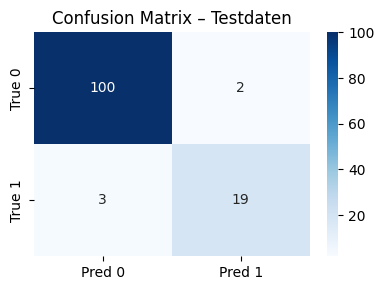

In [21]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# Wahre Labels aus data.csv rekonstruieren (gleicher Split wie oben)
_all_eval = pd.read_csv(os.path.join(DATA_DIR, "data.csv"))
_, _test_eval = train_test_split(
    _all_eval, test_size=0.2, random_state=42, stratify=_all_eval["Class"]
)
y_test_true = _test_eval["Class"].values
del _all_eval, _test_eval

# Vorhersagen (Klasse + Wahrscheinlichkeit)
y_test_pred  = (test_proba >= 0.5).astype(int)

# Metriken
acc       = accuracy_score(y_test_true, y_test_pred)
f1        = f1_score(y_test_true, y_test_pred, zero_division=0)
f1_macro  = f1_score(y_test_true, y_test_pred, average="macro", zero_division=0)
precision = precision_score(y_test_true, y_test_pred, zero_division=0)
recall    = recall_score(y_test_true, y_test_pred, zero_division=0)
bll       = balanced_log_loss(y_test_true, test_proba)

print("=" * 45)
print(f"  Accuracy          : {acc:.4f}")
print(f"  F1 (Class 1)      : {f1:.4f}")
print(f"  F1 Macro          : {f1_macro:.4f}")
print(f"  Precision         : {precision:.4f}")
print(f"  Recall            : {recall:.4f}")
print(f"  Balanced Log Loss : {bll:.4f}")
print("=" * 45)
print()
print(classification_report(y_test_true, y_test_pred, target_names=["Class 0", "Class 1"]))

# Confusion Matrix
cm = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix – Testdaten")
plt.tight_layout()
plt.show()

## Kleine Ablation-Idee (wenn Zeit bleibt)

- `do_winsorize=False` vs `True`
- `do_scale=False` vs `True`
- Calibration on/off

Ihr könnt das schnell als Tabelle in euren Report übernehmen.
